In [1]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer

In [10]:
TRAIN_PATH = "../../data/train/gpt_ann_short.csv"
TEST_PATH = "../../data/test/ann_combo.csv"

train_df = pd.read_csv(TRAIN_PATH)
train_df = train_df[train_df["gpt_cleaned"].isin([0, 1])] # some responses are nan
test_df = pd.read_csv(TEST_PATH)

texts_train, texts_test, labels_train, labels_test = train_df["paragraph_content"], test_df["paragraph_content"], train_df["gpt_cleaned"], test_df["new_annotations"]

# Convert text data into numerical features using TF-IDF
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(texts_train)
X_test = vectorizer.transform(texts_test)

# processed dataset: X_train, labels_train, X_test, labels_test

### XG Boost Classifier K-fold CV

In [ ]:
# Train the XGBoost model
model = xgb.XGBClassifier(n_jobs=-1)

param_grid = {
    'learning_rate':[0.01, 0.1, 0.2],
    'n_estimators':[50, 100, 200],
    'max_depth':[3, 5, 7],
    'min_child_weight':[1, 3, 5],
    'gamma':[0.1, 0.2, 0.3],
    'subsample':[0.6, 0.7, 0.8, 0.9],
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
metrics = ('accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'neg_log_loss')

gsearch = GridSearchCV(
    estimator = xgb.XGBClassifier(),
    param_grid = param_grid,
    scoring=metrics,
    n_jobs=-1,
    refit=False,
    cv=5,
    verbose=0
    )
gsearch.fit(X_train, labels_train)

results = pd.DataFrame(gsearch.cv_results_)
results.to_csv("xgboostResult.csv", index=False)

### CV Analysis

In [3]:
results = pd.read_csv("xgboostResult.csv")
columns_to_keep = ['params', 
                   'mean_test_accuracy', 'rank_test_accuracy', 
                   'mean_test_precision', 'rank_test_precision', 
                   'mean_test_recall', 'rank_test_recall', 
                   'mean_test_f1', 'rank_test_f1', 
                   'mean_test_roc_auc', 'rank_test_roc_auc', 
                   'mean_test_neg_log_loss', 'rank_test_neg_log_loss', 
                   ]
results = results[columns_to_keep]

# optimize for recall because false negatives immediately get filtered out, and the cost of false positives is not that bad
accuracy_mask = results['rank_test_accuracy'] <= 1
recall_mask = results['rank_test_recall'] <= 1
f1_mask = results['rank_test_f1'] <= 1
top = results[accuracy_mask & recall_mask & f1_mask]
for index, row in top.iterrows():
    print(row)
    best_parameters = row['params']
print(best_parameters)

params                    {'gamma': 0.3, 'learning_rate': 0.2, 'max_dept...
mean_test_accuracy                                                 0.955678
rank_test_accuracy                                                        1
mean_test_precision                                                0.977796
rank_test_precision                                                    4197
mean_test_recall                                                   0.873179
rank_test_recall                                                          1
mean_test_f1                                                       0.922505
rank_test_f1                                                              1
mean_test_roc_auc                                                  0.970621
rank_test_roc_auc                                                       165
mean_test_neg_log_loss                                            -0.146141
rank_test_neg_log_loss                                                    7
Name: 4543, 

### Adjusting threshold for the best XGBoost model

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [11]:
def getPredictions(output_margin, threshold):
    return np.where(output_margin >= threshold, 1, 0)

X_train_train_fold = X_train[:8000]; labels_train_train_fold = labels_train[:8000]
X_train_test_fold = X_train[8000:]; labels_train_test_fold = labels_train[8000:]

best_estimator = xgb.XGBClassifier(gamma=0.3, 
                                   learning_rate=0.2, 
                                   max_depth=5, 
                                   min_child_weight=1, 
                                   n_estimators=200, 
                                   reg_alpha=1e-05,
                                   subsample=0.9)
best_estimator.fit(X_train_train_fold, labels_train_train_fold)
outputs = best_estimator.predict(X_train_test_fold, output_margin=True)

thresholds = np.arange(-10, 10, 0.01)
recall_scores = [recall_score(labels_train_test_fold, getPredictions(outputs, thres)) for thres in thresholds]
f1_scores = [f1_score(labels_train_test_fold, getPredictions(outputs, thres)) for thres in thresholds]
precision_scores = [precision_score(labels_train_test_fold, getPredictions(outputs, thres)) for thres in thresholds]

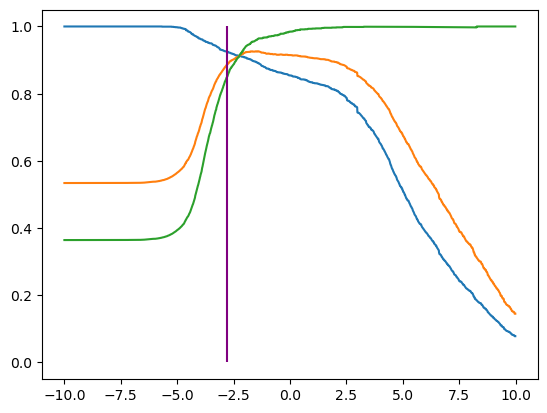

-2.780000000000154


In [12]:
# choose a precision score of 0.85 to be sufficient in order to get a higher recall score
precision_score_85_i = np.argmin(np.abs(np.array(precision_scores) - 0.85))
plt.plot(thresholds, recall_scores)
plt.plot(thresholds, f1_scores)
plt.plot(thresholds, precision_scores)
plt.vlines(x=thresholds[precision_score_85_i], ymin=0, ymax=1, colors='purple')
plt.show()
print(thresholds[precision_score_85_i])

### Running best XGBoost model optimized for recall on self-labeled test dataset

Accuracy: 91.07%
Precision: 90.41%
Recall: 96.28%
f1: 93.25%


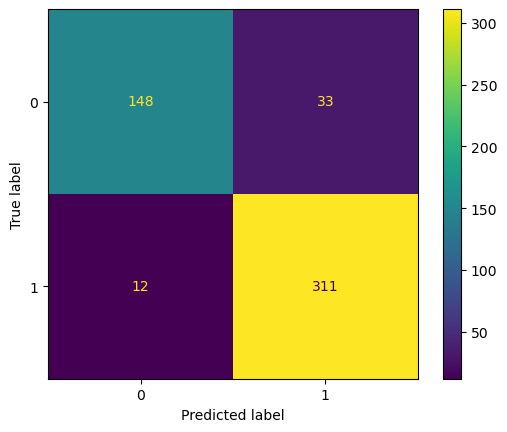

In [15]:
best_estimator.fit(X_train, labels_train)

outputs = best_estimator.predict(X_test, output_margin=True)
predictions = getPredictions(outputs, thresholds[precision_score_85_i])

accuracy = accuracy_score(labels_test, predictions)
precision = precision_score(labels_test, predictions)
recall = recall_score(labels_test, predictions)
f1 = f1_score(labels_test, predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("f1: {:.2f}%".format(f1 * 100))

cm = confusion_matrix(labels_test, predictions)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot()
plt.show()